# Guided Grad-CAM

Guided backpropagation is a combination of the gradient and deconvolution attribution methods. The deconvolution method discussed in [Deep Inside Convolutional Networks: Visualising Image Classification Models and Saliency Maps](https://arxiv.org/abs/1312.6034), was shown to be equivalent to a backward pass through the network, except for its interaction with the relu layer. The negative gradient values would be zeroed by relu, but the gradient values coming from negative input image values were not zeroed. Guided backpropagation method adapts this idea by **zeroing both negative gradients and gradients coming from negative input values**. We will implement this method by introducing a new relu layer called guided relu. Unfortunately guided relu performs poorly when training, so the model will first be trained with relu layers, then the relu layers will be swapped out for the guided relu layers when evaluating the attribution maps. There is no obvious way to swap layers in flax, so instead we will define a new model with the same architecture but guided relu inplace of relu layers.  

For more technical information on the guided backpropagation attribution method see: [Striving for Simplicity: The All Convolutional Net](https://arxiv.org/abs/1412.6806)


In [189]:

import os
import sys

notebook_dir = os.path.dirname(os.path.abspath('__file__'))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import jax.numpy as jnp


import jax
from jax import random
from jax import grad
import optax

import requests
import zipfile
import flaxmodels
from PIL import Image

from utils.image import *
from utils.plot import plot_image
from utils.save import save_image
from utils.guided_relu import guided_relu
from utils.classification import get_predictions

from algorithms.grad_cam import get_layer_activations, get_layer_gradients, get_layer_weights, get_layer_grad_cam, aggregate_scaled_grad_cams

In [190]:
world_net_id = 'n01534433' # The folder name in the imagenet_subset
img_idx = 75



img_name = f"{world_net_id}_{img_idx}"
image_path = f"storage/datasets/imagenet_subset/{img_name}.JPEG"
import os
os.getcwd() 

# Looks like the last Conv layer is the best.
LAYERS = [4]
LAYERS_IN_LAST_BLOCK = []


if len(LAYERS) > 0:
    save_dir = f"./output/{img_name}/layer4"
elif len(LAYERS_IN_LAST_BLOCK) > 0:
    save_dir = f"./output/{img_name}/last_block_layer3"
elif len(LAYERS_IN_LAST_BLOCK) == 0 and len(LAYERS)==0:
    raise ValueError("Please specify either LAYERS or LAYERS_IN_LAST_BLOCK")
else:
    raise ValueError("Only one of LAYERS or LAYERS_IN_LAST_BLOCK can be specified")

### Load training data
Here we choose not to use preprocessing. We found this to be very important for pretrained resnet's prediction.

In [191]:
rgb_img = read_and_normalize_image(image_path) 
# preprocessed_img = preprocess_image(rgb_img)
preprocessed_img = rgb_img

input_tensor = jnp.expand_dims(preprocessed_img, axis=0) # Whether to use preprocessing


H, W, C = (357, 500, 3)


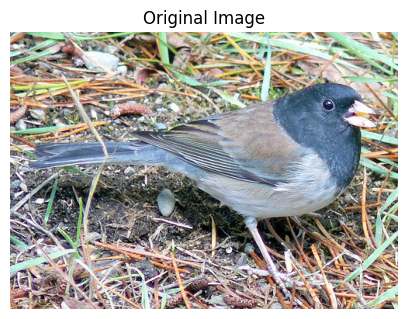

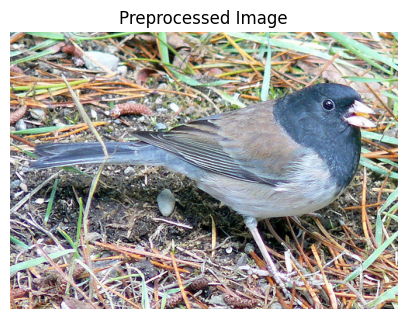

In [192]:

    
H, W, C = rgb_img.shape
print(f"H, W, C = {rgb_img.shape}")
plot_image(rgb_img, title='Original Image')
plot_image(preprocessed_img, title='Preprocessed Image')


# Create model with grad-cam hook

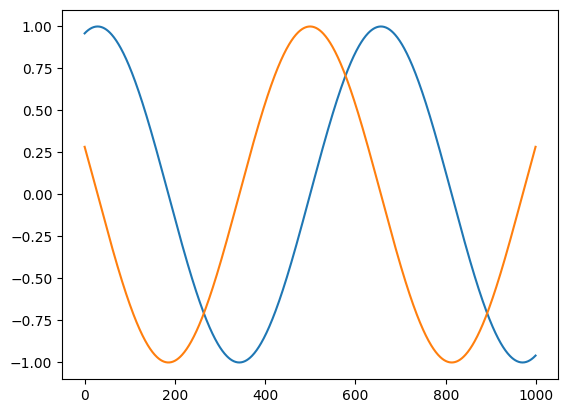

In [193]:
input_vector = jnp.linspace(-5, 5, 1000)

plt.plot(jnp.sin(input_vector))
plt.plot(jax.vmap(grad(jnp.sin))(input_vector))

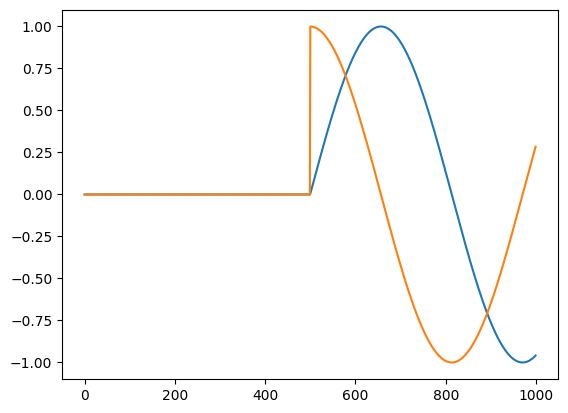

In [194]:
def relu_sin(x):
    x = jax.nn.relu(x)
    return jnp.sin(x)

plt.plot(relu_sin(input_vector))
plt.plot(jax.vmap(grad(relu_sin))(input_vector))

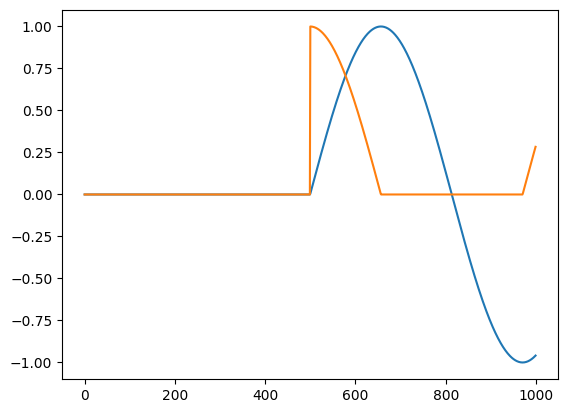

In [195]:
def guided_relu_sin(x):
    x = guided_relu(x)
    return jnp.sin(x)

plt.plot(guided_relu_sin(input_vector))
plt.plot(jax.vmap(grad(guided_relu_sin))(input_vector))

In [196]:
guided_grad_cam_model = flaxmodels.ResNet50Customized(output='logits', pretrained='imagenet', customized_relu=guided_relu, observe_layers=LAYERS, observe_layers_in_last_block=LAYERS_IN_LAST_BLOCK)
vanilla_model = flaxmodels.ResNet50(output='logits', pretrained='imagenet')

rng_key = random.PRNGKey(0)

variables = guided_grad_cam_model.init(rng_key, input_tensor) # {'params': ..., 'batch_stats': ..., 'perturbations': ...}

logits = guided_grad_cam_model.apply(variables, input_tensor, train=False)
prediction = get_predictions(logits)
print(prediction) # probabilities for 1000 classes

# print(model.tabulate(rng_key, input_tensor))
# print(variables)


[13]


### Display predictions and attribution maps

The final convolutional layer values and gradients are required to perform Grad-CAM. To access the convolutional layer it needs to be stored as an intermediate variable in the model definition, then the "mutable='intermediates'" argument is supplied to the model when performing the forward pass. The gradients of the final convolutional layer is extracted by passing the final convolutional layers values as a perturbation parameter to the loss function, then calculating the gradients of the perturbation parameter. Global average pooling is then applied to the convolutional layers gradients to extract the weightings. This is performed by taking the mean of each filter/feature map, this results in a vector of floats with the size of the number of feature maps. The vector is then used as weights for the feature maps. The dot product is taken between the weights and feature maps to provide us with the class activation mapping. 

### Create new loss function with guided model

A new loss function containing the model with guided relu layers is required when performing gradient calculations for the attribution attribution maps.

In [197]:
def loss_fn(model, params, batch_stats, perturbations, X, Y):
    '''
    Classification loss function.
    In both Guided BP and Grad-CAM , we want to get the grad of the last layer w.r.t. the target label, instead of the loss.
    To do this, we still define the loss function, but we use the negated gradients, since d(-L) / dx == - d(L) / dx
    '''
    variables = {
        'params': params,
        'batch_stats': batch_stats,
        'perturbations': perturbations
    }
    
    logits = model.apply(variables, X, train=False)
    predictions = get_predictions(logits)
    
    logit_for_pred = logits[0, predictions[0]]
    loss = optax.softmax_cross_entropy_with_integer_labels(logits, Y)
    loss = loss.mean()
    return loss

### Display predictions and attribution maps

The gradients are calculated with the new guided loss function. The gradients are then normalized in the standard way for visualization.

In [198]:



def make_predictions(model, variables, X):
    logits, state = model.apply(variables, X, train=False, mutable='intermediates')
    predictions = get_predictions(logits)
    return predictions, state

    

def guided_grad_cam_func(model, variables, rgb_img, input_tensor, vanilla_model, target=None):
    prediction, state = make_predictions(model, variables, input_tensor)
    if target is None:
        target = prediction
    print("Prediction: ", prediction)
    print("Target: ", target)
    
    # For input image
    B, H, W, C = input_tensor.shape
    assert B==1
    
    #################################################
    # Grad-CAM
    #################################################
    scaled_layer_grad_cams = []
    target_shape = (H, W, C)
    
    if len(LAYERS) > 0:
        for idx in LAYERS:
            layer_activations = get_layer_activations(state, layer_idx=idx) # (B, H', W', C')
            layer_grads = get_layer_gradients(model, variables, layer_activations, input_tensor, target, loss_fn, layer_idx=idx) # (B, H', W', C')
            layer_weights = get_layer_weights(layer_grads) # (B, C')
            layer_grad_cam = get_layer_grad_cam(layer_weights, layer_activations) # (B, H', W', 1)
        
            scaled_layer_grad_cam = scale_cam_image(layer_grad_cam, target_shape) # (B, H', W', 1) --> (B, H, W, 1)
            scaled_layer_grad_cams.append(scaled_layer_grad_cam)
    elif len(LAYERS_IN_LAST_BLOCK) > 0:
        for idx in LAYERS_IN_LAST_BLOCK:
            layer_activations = get_layer_activations(state, layer_idx=idx, within_block=True) # (B, H', W', C')
            layer_grads = get_layer_gradients(model, variables, layer_activations, input_tensor, target, loss_fn, layer_idx=idx, within_block=True) # (B, H', W', C')
            
            layer_weights = get_layer_weights(layer_grads) # (B, C')
            layer_grad_cam = get_layer_grad_cam(layer_weights, layer_activations) # (B, H', W', 1)
        
            scaled_layer_grad_cam = scale_cam_image(layer_grad_cam, target_shape) # (B, H', W', 1) --> (B, H, W, 1)
            scaled_layer_grad_cams.append(scaled_layer_grad_cam)
    else:
        raise ValueError("LAYERS or LAYERS_IN_LAST_BLOCK should be provided.")
        
    
    grad_cam = aggregate_scaled_grad_cams(scaled_layer_grad_cams) # (B, H, W, 1)
    grad_cam = grad_cam[0, :] # Only one image (H, W, 1)
    #################################################
    #################################################
    
    #################################################
    # Vanila Gradient Method
    #################################################
    attributions_map = -grad(loss_fn, argnums=4)(vanilla_model, variables['params'], variables['batch_stats'], variables['perturbations'], input_tensor, target) # negated grad
    attributions_map = attributions_map[0, :]
    #################################################
    #################################################
    
    
    #################################################
    # Guided BP 
    #################################################
    guided_attributions_map = -grad(loss_fn, argnums=4)(model, variables['params'], variables['batch_stats'], variables['perturbations'], input_tensor, target) # negated grad
    guided_attributions_map = guided_attributions_map[0, :]
    #################################################
    #################################################
    
    
    #################################################
    # Guided Grad-CAM
    #################################################
    # cam_mask = cv2.merge([grayscale_cam, grayscale_cam, grayscale_cam])
    cam_mask = jnp.concatenate([grad_cam]*3, axis=-1)
    guided_cam_image = cam_mask * guided_attributions_map
    grad_cam_image = show_cam_on_image(rgb_img, grad_cam, 0.5)
    #################################################
    #################################################
    
    # Visualization
    grad_cam_image = show_cam_on_image(rgb_img, grad_cam, 0.5)
    attributions_map = deprocess_image(attributions_map)
    guided_attributions_map = deprocess_image(guided_attributions_map)
    guided_cam_image = deprocess_image(guided_cam_image)

    return grad_cam_image, attributions_map, guided_attributions_map, guided_cam_image

In [199]:
grad_cam_image, attributions_map, guided_attributions_map, guided_cam_image = guided_grad_cam_func(guided_grad_cam_model, variables, rgb_img, input_tensor, vanilla_model, target=None)

Prediction:  [13]
Target:  [13]


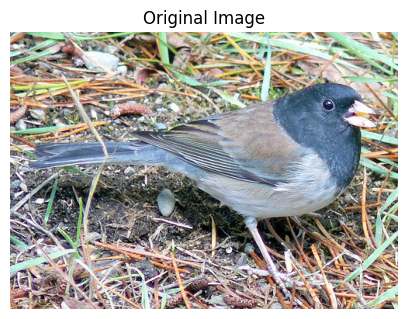

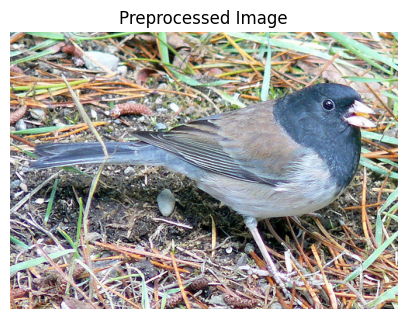

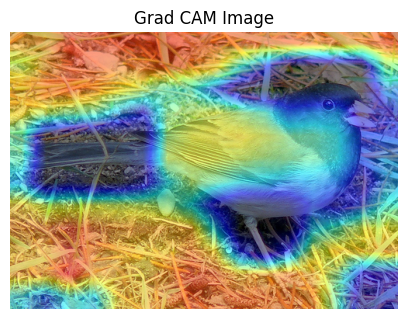

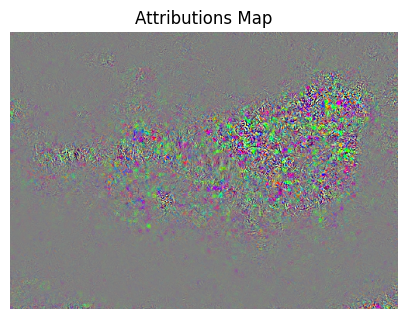

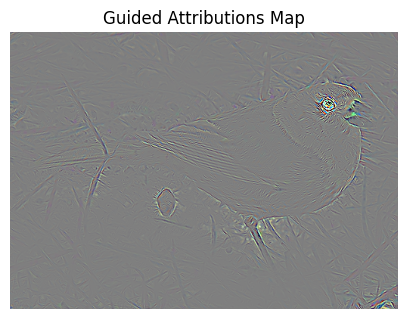

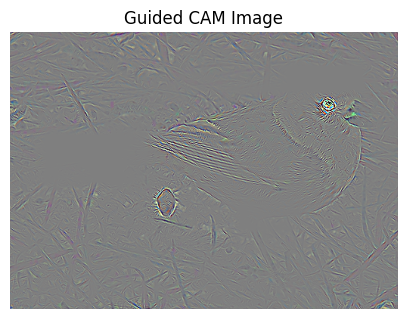

In [200]:

# List of images and titles
images = [rgb_img, preprocessed_img, grad_cam_image, attributions_map, guided_attributions_map, guided_cam_image]
titles = ['Original Image', 'Preprocessed Image', 'Grad CAM Image', 'Attributions Map', 'Guided Attributions Map', 'Guided CAM Image']

# Plot and save each image
for image, title in zip(images, titles):
    plot_image(image, title=title, figsize=(5, 5))
    save_image(image, title=title, save_dir=save_dir, save_format='png')